In [2]:
%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression
import pymysql
import pandas as pd
import scipy
import sys, io, os
sys.path.append(os.path.abspath(os.path.dirname('../../code/')))
from Database import Database, Partition
import CostFunction
import seaborn
import matplotlib.pyplot as plt

CostFunction.py Not in Command line Mode


In [3]:
partition = Partition('PA')
database = Database(partition)
costfunction = CostFunction.CostFunction(database)

In [4]:
connection = pymysql.connect(user='root', password='root',
                              host='localhost',
                              db='drug_database')

info_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='drug_information')

presc_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='prescription_aggregates')

aggregate_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='drug_aggregates')
opt_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='optimization_tables')

In [5]:
def get_observation_values(selected_specialty, selected_drug):
    cursor = info_connection.cursor()
    cursor.execute("""
    SELECT npi, specialty_description, drug_name, total_claim_count, total_day_supply, drug_cost,
    total_claim_count / drug_cost as claim_per_dollar, total_day_supply / total_claim_count as supply_per_claim,
    drug_cost / total_claim_count as cost_per_claim
    FROM pa_state_spl_drug_npi
    WHERE specialty_description = '{0}' AND drug_name = '{drug_name}'
    """.format(selected_specialty, drug_name=selected_drug))
    specialty_values = cursor.fetchall()
    cursor.close()
    return specialty_values

In [6]:
def get_mean_values(selected_specialty, selected_drug):
    cursor = opt_connection.cursor()
    cursor.execute("""
    SELECT pa_cost_function.npi, pa_cost_function.specialty_description, pa_cost_function.drug_name,
    specialty_mean_claim_per_dollar, specialty_mean_supply_per_claim, specialty_mean_cost_per_claim,
    specialty_std_claim_per_dollar, specialty_std_supply_per_claim, specialty_std_cost_per_claim,
    drug_mean_claim_per_dollar, drug_mean_supply_per_claim, drug_mean_cost_per_claim,
    drug_std_claim_per_dollar, drug_std_supply_per_claim, drug_std_cost_per_claim
    FROM pa_cost_function 
    INNER JOIN drug_information.pa_state_spl_drug_npi ON
    pa_state_spl_drug_npi.specialty_description = pa_cost_function.specialty_description
    AND pa_state_spl_drug_npi.drug_name = pa_cost_function.drug_name
    WHERE pa_cost_function.specialty_description = '{0}' AND pa_cost_function.drug_name = '{drug_name}'
    GROUP BY pa_state_spl_drug_npi.specialty_description, pa_state_spl_drug_npi.drug_name
    """.format(selected_specialty, drug_name=selected_drug))
    aggregated_values = cursor.fetchone()
    cursor.close()
    return aggregated_values

In [7]:
# MMSE when only specialties are taken into consideration
prescription = {"specialty_description": "Cardiology", "drug_name": "FLUTICASONE PROPIONATE"}
selected_specialty = prescription["specialty_description"]
selected_drug = prescription["drug_name"]

specialty_values = get_observation_values(selected_specialty, selected_drug)
y_values = np.array(specialty_values)
measurement_values = np.array(y_values[:, 6:], dtype=np.dtype(np.float64))
y_mean = np.mean(measurement_values, axis=0)

new_specialty = 'Endocrinology'
new_drug = 'NOVOLOG FLEXPEN'
observation = get_observation_values(new_specialty, new_drug)
x_values = np.array(observation)
estimation_values = np.array(x_values[:, 6:], dtype=np.dtype(np.float64))
x_mean = np.mean(estimation_values, axis=0)
mean_value_items = np.array(get_mean_values(new_specialty, new_drug))
estimation_mean_values = np.array(mean_value_items[3:], dtype=np.dtype(np.float64))
phi_mean = np.array([estimation_mean_values[0], estimation_mean_values[1], estimation_mean_values[2]])

covariance_matrix = np.cov(np.mean(np.square(estimation_values[:, 0:2] - phi_mean[0:2]), axis=0), 
                     np.mean(np.square(measurement_values[:, 0:2] - phi_mean[0:2]), axis=0))

cov_xy = covariance_matrix[0, 1]
cov_y = covariance_matrix[1, 1]

# MMSE vector for Safety and Claim per Dollar (used for calculating local optima and maxima)
x_cap_claim_per_dollar = x_mean[0] + (cov_xy / cov_y) * (measurement_values[:, 0] - y_mean[0])

# MMSE vector for Safety and Supply per Claim
x_cap_supply_per_claim = x_mean[1] + (cov_xy / cov_y) * (measurement_values[:, 1] - y_mean[1])

# MSE estimation (takes global mean into perspective)
phi_cap_claim_per_dollar = phi_mean[0] + ( cov_xy / cov_y ) * (measurement_values[:, 0] - y_mean[0])
phi_cap_supply_per_claim = phi_mean[1] + ( cov_xy / cov_y ) * (measurement_values[:, 1] - y_mean[1])

print("Measurement ('Allergy/Immunology', 'XOLAIR') v/s Observation ('Physician Assistant', 'NOVOLOG')", "\n")
print("The Average of Mean Square Estimation (MSE) Value is: ", 
      np.mean(np.array([phi_cap_claim_per_dollar, phi_cap_supply_per_claim]), axis=1), "\n")
print("The Average of Minimum Mean Square Estimation (MMSE) Value is: ", 
      np.mean(np.array([x_cap_claim_per_dollar, x_cap_supply_per_claim]), axis=1))

Measurement ('Allergy/Immunology', 'XOLAIR') v/s Observation ('Physician Assistant', 'NOVOLOG') 

The Average of Mean Square Estimation (MSE) Value is:  [  2.39793523e-02   5.03216263e+01] 

The Average of Minimum Mean Square Estimation (MMSE) Value is:  [  1.43958761e-03   4.96767214e+01]


In [8]:
import numpy as np
import scipy
import pymysql
import os, sys, io
sys.path.append(os.path.abspath(os.path.dirname('../code/')))
from scipy.optimize import minimize
from Database import Database, Partition
import CostFunction
import Optimization.canberra_distance as canberra_distance
import math

In [9]:
class SpecialtyWeight():
    
    def __init__(self, prescription):
        params = self.OrderParameters(prescription)
        self.order_number = self.find_order_number(params, prescription)
        self.params = params
    
    def OrderParameters(self, new_prescription):
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT MAX(specialty_std_claim_per_dollar / specialty_mean_claim_per_dollar),
        specialty_mean_supply_per_claim / specialty_std_supply_per_claim,
        claim_per_dollar, supply_per_claim, pa_specialty_entropy.npi_count,
        pa_specialty_entropy.drug_count,
        pa_cost_function.npi_day_supply
        FROM pa_cost_function
        INNER JOIN claim_aggregates.pa_specialty_entropy ON 
        pa_specialty_entropy.specialty_description = pa_cost_function.specialty_description
        WHERE pa_cost_function.specialty_description = '{specialty_description}'
        ORDER BY MAX(specialty_std_claim_per_dollar / specialty_mean_claim_per_dollar) DESC,
        specialty_mean_supply_per_claim / specialty_std_supply_per_claim DESC,
        claim_per_dollar DESC, supply_per_claim desc,
        pa_specialty_entropy.npi_count DESC,
        pa_specialty_entropy.drug_count DESC,
        pa_cost_function.npi_day_supply DESC
        LIMIT 0,1
        """.format(**new_prescription))
        max_values = dict(zip(['max', 'ratio','claim_per_dollar', 'supply_per_claim', 
                       'npi_count', 'drug_count', 'npi_day_supply'], cursor.fetchone()))
        cursor.close()
        return max_values
    
    def find_order_number(self, max_values, new_prescription):
        params = {**max_values, **new_prescription}
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT COUNT(*)
        FROM pa_cost_function
        INNER JOIN claim_aggregates.pa_specialty_entropy ON 
        pa_specialty_entropy.specialty_description = pa_cost_function.specialty_description
        WHERE (specialty_std_claim_per_dollar / specialty_mean_claim_per_dollar) <= {max} AND
        (specialty_mean_supply_per_claim / specialty_std_supply_per_claim) <= {ratio} AND
        pa_specialty_entropy.npi_count <= {npi_count} AND
        pa_specialty_entropy.drug_count <= {drug_count} AND
        pa_cost_function.npi_day_supply <= {npi_day_supply} AND
        claim_per_dollar <= {claim_per_dollar} AND
        supply_per_claim <= {supply_per_claim}
        ORDER BY 
        pa_specialty_entropy.npi_count DESC,
        pa_specialty_entropy.drug_count desc,
        pa_cost_function.npi_day_supply DESC
        """.format(**params))
        length = cursor.fetchone()
        cursor.close()
        return length
    
class DrugWeight():
    
    def __init__(self, prescription):
        params = self.OrderParameters(prescription)
        self.order_number = self.find_order_number(params, prescription)
        self.params = params
    
    def OrderParameters(self, new_prescription):
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT MAX(specialty_std_claim_per_dollar / specialty_mean_claim_per_dollar),
        specialty_mean_supply_per_claim / specialty_std_supply_per_claim,
        cost_per_claim, supply_per_claim,
        swd.prescribers, swd.part_d_claims, pct.total_day_supply
        FROM pa_cost_function
        INNER JOIN drug_aggregates.state_wise_drug_state swd
        ON swd.drug_name = pa_cost_function.drug_name AND
        swd.state = 'Pennsylvania'
        INNER JOIN drug_information.pa_cost_quality_table pct
        ON pct.specialty_description = pa_cost_function.specialty_description
        WHERE pa_cost_function.drug_name = '{drug_name}' AND swd.state = 'Pennsylvania'
        ORDER BY MAX(specialty_std_claim_per_dollar / specialty_mean_claim_per_dollar) DESC,
        specialty_mean_supply_per_claim / specialty_std_supply_per_claim desc,
        cost_per_claim DESC, supply_per_claim DESC,
        swd.prescribers desc, swd.part_d_claims desc, pct.total_day_supply DESC
        LIMIT 0,1
        """.format(**new_prescription))
        max_values = dict(zip(['max', 'ratio', 'cost_per_claim', 'supply_per_claim', 'prescribers', 'part_d_claims', 
                       'total_day_supply'], cursor.fetchone()))
        cursor.close()
        return max_values
    
    def find_order_number(self, max_values, new_prescription):
        params = {**max_values, **new_prescription}
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT COUNT(*)
        FROM pa_cost_function
        INNER JOIN claim_aggregates.pa_specialty_entropy ON 
        pa_specialty_entropy.specialty_description = pa_cost_function.specialty_description
        INNER JOIN drug_aggregates.state_wise_drug_state swd
        ON swd.drug_name = pa_cost_function.drug_name AND
        swd.state = 'Pennsylvania'
        INNER JOIN drug_information.pa_cost_quality_table pct
        ON pct.specialty_description = pa_cost_function.specialty_description
        WHERE (specialty_std_claim_per_dollar / specialty_mean_claim_per_dollar) <= {max} AND
        (specialty_mean_supply_per_claim / specialty_std_supply_per_claim) <= {ratio} AND
        swd.prescribers <= {prescribers} AND
        swd.part_d_claims <= {part_d_claims} AND
        pct.total_day_supply <= {total_day_supply} AND
        cost_per_claim <= {cost_per_claim} AND
        supply_per_claim = {supply_per_claim} AND
        swd.state = 'Pennsylvania'
        ORDER BY 
        swd.prescribers DESC,
        swd.part_d_claims DESC,
        pct.total_day_supply DESC
        """.format(**params))
        number = cursor.fetchone()
        cursor.close()
        return number
        
def find_classes(prescription, table="pa_kmeans_y_pred_spl_weight"):
    cursor = database.opt_connection.cursor()
    cursor.execute("""
    SELECT COUNT(DISTINCT batch, cluster) as batch_cluster
    FROM """ + table + """
    WHERE drug_name = '{0}' AND specialty_description = '{1}'; """.format(prescription[0], prescription[1]))
    item = cursor.fetchone()
    cursor.close()
    return item[0]

def find_joint_classes(prescription, existing_prescription, table="pa_kmeans_y_pred_spl_weight"):
    cursor = database.opt_connection.cursor()
    cursor.execute("""
    SELECT COUNT(DISTINCT batch, cluster) as batch_cluster
    FROM """ + table + """
    WHERE (drug_name = '{0}' AND specialty_description = '{1}')
    OR (drug_name = '{2}' AND specialty_description = '{3}')
    """.format(prescription[0], prescription[1], existing_prescription[0], existing_prescription[1]))
    item = cursor.fetchone()
    cursor.close()
    return item[0]

def observation_values(selected_specialty, selected_drug):
    cursor = database.info_connection.cursor()
    cursor.execute("""
    SELECT npi, specialty_description, drug_name, total_claim_count, total_day_supply, drug_cost,
    total_claim_count / drug_cost as claim_per_dollar, total_day_supply / total_claim_count as supply_per_claim,
    drug_cost / total_claim_count as cost_per_claim
    FROM pa_state_spl_drug_npi
    WHERE specialty_description = '{0}' AND drug_name = '{drug_name}'
    """.format(selected_specialty, drug_name=selected_drug))
    specialty_values = cursor.fetchall()
    cursor.close()
    return specialty_values

def mean_values(selected_specialty, selected_drug):
    cursor = database.opt_connection.cursor()
    cursor.execute("""
    SELECT npi, specialty_description, drug_name,
    specialty_mean_claim_per_dollar, specialty_mean_supply_per_claim, specialty_mean_cost_per_claim,
    specialty_std_claim_per_dollar, specialty_std_supply_per_claim, specialty_std_cost_per_claim,
    AVG(), drug_mean_supply_per_claim, drug_mean_cost_per_claim,
    , drug_std_supply_per_claim, drug_std_cost_per_claim
    FROM pa_cost_function 
    INNER JOIN pa_state_spl_drug_npi ON
    pa_state_spl_drug_npi.specialty_description = pa_cost_function.specialty_description
    AND pa_state_spl_drug_npi.drug_name = pa_cost_function.drug_name
    WHERE pa_cost_function.specialty_description = '{0}' AND pa_cost_function.drug_name = '{drug_name}'
    GROUP BY pa_state_spl_drug_npi.specialty_description, pa_state_spl_drug_npi.drug_name
    """.format(selected_specialty, drug_name=selected_drug))
    aggregated_values = cursor.fetchone()
    cursor.close()
    return aggregated_values

class CanberraDistance():
        
    def __init__(self, canberra_npi):
        self.canberra_npi = canberra_npi

    def measure_distance(self, cluster_batch_data):
        canberra_cluster = []
        
        for item in cluster_batch_data:
            canberra_cluster.append(scipy.spatial.distance.canberra(self.canberra_npi, item[3:]))
        return canberra_cluster

class MMSEEstimation():

    def __init__(self, measurement_pair, observation_pair, optimizer):
        self.measurement_pair = measurement_pair
        self.observation_pair = observation_pair
        self.optimizer = optimizer

    def get_estimation_probability(self, cluster, batch, observation_pair, measurement_pair, table="pa_kmeans_y_pred_spl_weight"):
        prob_measurement = self.optimizer.probability_specialty_drug(measurement_pair, table=table)['calculated_probability']
        prob_observation_measurement = self.optimizer.cluster_batch_joint_probability_specialty_drug(
            measurement_pair, observation_pair, cluster, batch, table=table)['calculated_probability']
        prob_observation = self.optimizer.cluster_batch_probability_specialty_drug(
            observation_pair, cluster, batch, table=table)['calculated_probability']
        return [prob_measurement, prob_observation_measurement, prob_observation]
    
    def estimate_value(self, table="pa_kmeans_y_pred_spl_weight"):
        # Probability
        prob_measurement = self.optimizer.probability_specialty_drug(self.measurement_pair, table=table)['calculated_probability']
        prob_measurement_observation = self.optimizer.joint_probability_specialty_drug(
            self.measurement_pair, self.observation_pair, table=table)['calculated_probability']
        prob_observation = self.optimizer.probability_specialty_drug(self.observation_pair, table=table)['calculated_probability']

        # Observation
        observation_expectation = self.observation_quantity * prob_measurement_observation / prob_measurement
        return observation_expectation

    def measurement_expectation(self, table="pa_kmeans_y_pred_spl_weight"):
        # Probability
        prob_measurement = self.optimizer.probability_specialty_drug(self.measurement_pair, table=table)['calculated_probability']
        prob_observation_measurement = self.optimizer.joint_probability_specialty_drug(
            self.observation_pair, self.measurement_pair, table=table)['calculated_probability']
        prob_observation = self.optimizer.probability_specialty_drug(self.observation_pair, table=table)['calculated_probability']

        # Measurement
        measurement_expectation = self.measurement_quantity * prob_observation_measurement / prob_observation
        return measurement_expectation

    def set_data_points(self, measurement_values, estimation_values):
        self.measurement_quantity = measurement_values
        self.observation_quantity = estimation_values
        
    def calculate_covariance(self, estimation_values, start, end):
        measurement_values = self.measurement_quantity
        covariance_matrix = np.cov(np.mean(np.square(estimation_values[:, start:end] - phi_mean[start:end]), axis=0), 
                                   np.mean(np.square(measurement_values[:, start:end] - phi_mean[start:end]), axis=0))
        return covariance_matrix
    
    def predict_value(self, x_mean, y_mean, estimation_values, start):
        x_cap = x_mean[start] + (cov_xy / cov_y) * (estimation_values[:, start] - y_mean[start])
        return x_cap

class ClassificationCost():

    def __init__(self, x, y, xy, mutual_information, mmse):
        self.mutual_information = mutual_information
        self.x = x
        self.y = y
        self.xy = xy
        self.mmse = mmse
        
    def evaluate_priority(self, npi, cluster, batch, observation_pair, measurement_pair, table="pa_kmeans_y_pred_spl_weight"):
        # priority becomes our mmse estimation probability of observation given measurement
        probabilities = self.mmse.get_estimation_probability(cluster, batch, observation_pair, measurement_pair, table=table)
        if probabilities[2] == 0:
            return 0
        return probabilities[1] / probabilities[2]
        
    def evaluate_priority_with_covariance(self, npi, prescription):
        return None

    # Classify for claims
    def calculate_cost(self, prescription, cluster, batch, table='pa_kmeans_y_pred_spl_weight'):
        cursor = database.opt_connection.cursor()
        self.cluster = cluster
        self.batch = batch
        cursor.execute("""
        SELECT specialty_description, drug_name, npi FROM """ + table + """
        WHERE cluster = '{cluster}' AND batch = '{batch}'
        """.format(cluster=cluster, batch=batch))
        cluster_batches = np.array(cursor.fetchall())
        cursor.close()
        net_cluster = dict()
        net_cluster[cluster.__str__() + "__" + batch.__str__()] = 0 # Assigning priority for classification
        if len(cluster_batches) > 0:
            priority = 0
            total_claim = 0
            claim_array = []
            npi_collection = cluster_batches[:, 2]
            for npi in npi_collection.tolist():
                cursor = database.info_connection.cursor()
                cursor.execute("""
                SELECT total_claim_count FROM pa_state_spl_drug_npi
                WHERE npi = '{0}'
                """.format(npi))
                claim = cursor.fetchone()[0]
                claim_array.append(claim)
                cursor.close()
            idx = 0
            total_claim = sum(claim_array)
            for npi in npi_collection.tolist():
                priority = priority + self.mmse.optimizer.mutual_information(
                prescription=(cluster_batches[idx, 1], cluster_batches[idx, 0]),
                existing_prescription=(prescription["drug_name"],prescription["specialty_description"]),
                factor=0)*(1+1/((claim_array[idx]/total_claim)*(1+self.evaluate_priority(
                    npi,
                    cluster,batch,
                    (prescription["drug_name"], prescription["specialty_description"]),
                    (cluster_batches[idx, 1], cluster_batches[idx, 0]),table=table))))
                idx = idx + 1
        else:
            return 0

        return 1/len(cluster_batches) * priority

    def calculate_deviance(self, prescription, table='pa_kmeans_y_pred_spl_weight', optimization=None):
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT npi, specialty_description, drug_name, cluster, batch FROM
        """ + table + """
        WHERE specialty_description = '{specialty_description}' AND drug_name = '{drug_name}'
        """.format(**optimization.prescription))
        items = cursor.fetchall()
        cursor.close()
        value = 0
        try:
            for item in items:
                pi_c = self.calculate_cost(prescription, item[3], item[4], table=table)
                if pi_c != 0:
                    append_value = pi_c * math.log(pi_c)
                else:
                    append_value = 0
                value = value + append_value
        except Exception as e:
            print(pi_c)
            raise e
        return value

class Optimization():

    database = None
    total_batches = 52
    total_clusters = 300
    
    def __init__(self, db, prescription, state='PA', factor=None, table="pa_kmeans_y_pred_spl_weight"):
        database = db
        self.prescription = prescription
        self.table_name = table
        self.state = state
        self.factor = factor
        self.total_batches = self.calculate_net_cluster_size()
        self.canberra = CanberraDistance(canberra_distance.get_canberra_distance_npi(**prescription))
        
    def set_mmse(self, measurement_pair, observation_pair):
        self.mmse = MMSEEstimation(measurement_pair, observation_pair, self)
        return self.mmse
    
    def classification_cost(self, value, mmse, cluster, batch):
        cost = ClassificationCost(mutual_information=value, x=self.npix_specialty_drug_probability, 
                y=self.npiy_specialty_drug_probability, xy=self.joint_probability, mmse=mmse)
        return cost.calculate_cost(
            cluster=cluster, 
            batch=batch, 
            table='pa_kmeans_y_pred_drug_weight', 
            prescription=self.prescription)
        
    def calculate_net_cluster_size(self):
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT COUNT(DISTINCT(batch)) as batch_size,
        COUNT(DISTINCT cluster) as cluster_size
        FROM """ + self.table_name + """
        """)
        results = cursor.fetchone()
        cursor.close()
        return results[0] * results[1]
    
    # Mutual Information for evaluating cost and quality
    def mutual_information(self, prescription, existing_prescription, factor):
        order_number = self.factor.order_number
        npix_specialty_drug_probability = self.probability_specialty_drug(prescription, table=self.table_name)
        npiy_specialty_drug_probability = self.probability_specialty_drug(existing_prescription, table=self.table_name)
        self.npix_specialty_drug_probability = npix_specialty_drug_probability
        self.npiy_specialty_drug_probability = npiy_specialty_drug_probability
        
        joint_probability = self.joint_probability_specialty_drug(prescription, existing_prescription, 
                                  table=self.table_name)
        self.joint_probability = joint_probability
        
        cursor = database.info_connection.cursor()
        cursor.execute("""
        SELECT (drug_cost / total_claim_count) / (total_day_supply / fill_count), npi FROM 
        pa_state_spl_drug_npi
        WHERE specialty_description = '{0}' AND drug_name = '{1}'
        """.format(prescription[1], prescription[0]))
        x_values = cursor.fetchall()
        cursor.close()
        
        cursor = database.info_connection.cursor()
        cursor.execute("""
        SELECT COUNT(DISTINCT npi) FROM pa_state_spl_drug_npi
        WHERE (drug_name = '{0}' AND specialty_description = '{1}')
        OR (drug_name = '{2}' AND specialty_description = '{3}')
        """.format(prescription[0], prescription[1], existing_prescription[0], existing_prescription[1]))
        joint_total = cursor.fetchone()
        joint_total = joint_total[0]
        cursor.close()
        
        value = 0
        for item in x_values:
            prob_xy = joint_total / ( joint_probability['net_drug_cases'] )
            over_x_value = item[0] * prob_xy * math.log( prob_xy / 
                  ((npix_specialty_drug_probability['specialty_drug_total'] / 
                    npix_specialty_drug_probability['drug_total']) * 
             (npiy_specialty_drug_probability['specialty_drug_total'] / 
              npiy_specialty_drug_probability['drug_total'])))
            value = value + over_x_value
        return value
    
    def cluster_batch_probability_specialty_drug(self, prescription, cluster, batch, 
                                                 table="pa_kmeans_y_pred_spl_weight"):
        if not prescription:
            prescription = self.prescription
        total_batches = self.total_batches
        cursor = database.info_connection.cursor()
        cursor.execute("""
        SELECT COUNT(DISTINCT npi) as count FROM """ + partition.state + 
        """_state_spl_drug_npi WHERE drug_name = '{drug_name}' AND 
        specialty_description = '{specialty_description}'
        """.format(drug_name=prescription[0], 
            specialty_description=prescription[1]))
        drug_name = prescription[0]
        specialty_description = prescription[1]

        result = cursor.fetchone()
        specialty_drug_total = result[0]
        cursor.close()
        
        batch_cluster_sum = 0
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT cluster, batch, npi FROM """ + table + """
        WHERE specialty_description = '{specialty_description}' AND drug_name = '{drug_name}'
        """.format(drug_name=prescription[0], specialty_description=prescription[1]))
        cluster_batches = np.array(cursor.fetchall())
        cursor.close()
        
        total_batches = len(cluster_batches)
        for item in cluster_batches:
            if item[0] == cluster and item[1] == batch:
                batch_cluster_sum = batch_cluster_sum + 1
        
        cursor = database.info_connection.cursor()
        cursor.execute("""
        SELECT COUNT(DISTINCT npi) as count FROM """ + partition.state + """_state_spl_drug_npi
        WHERE drug_name = '{drug_name}'
        """.format(drug_name=drug_name))
        result = cursor.fetchone()
        drug_total = result[0]
        cursor.close()

        return {'calculated_probability': batch_cluster_sum * specialty_drug_total / (total_batches * drug_total),
               'batch_cluster_sum': batch_cluster_sum,
                'specialty_drug_total': specialty_drug_total,
                'drug_total': drug_total
               }
    
    def probability_specialty_drug(self, prescription=None, table="pa_kmeans_y_pred_spl_weight"):
        if not prescription:
            prescription = self.prescription
        total_batches = self.total_batches
        cursor = database.info_connection.cursor()
        cursor.execute("""
        SELECT COUNT(DISTINCT npi) as count FROM """ + partition.state + 
        """_state_spl_drug_npi WHERE drug_name = '{drug_name}' AND 
        specialty_description = '{specialty_description}'
        """.format(drug_name=prescription[0], 
            specialty_description=prescription[1]))
        drug_name = prescription[0]
        specialty_description = prescription[1]

        batch_cluster_sum = find_classes(prescription, table=self.table_name)
        result = cursor.fetchone()
        specialty_drug_total = result[0]
        cursor.close()
        
        cursor = database.info_connection.cursor()
        cursor.execute("""
        SELECT COUNT(DISTINCT npi) as count FROM """ + partition.state + """_state_spl_drug_npi
        WHERE drug_name = '{drug_name}'
        """.format(drug_name=drug_name))
        result = cursor.fetchone()
        drug_total = result[0]
        cursor.close()
        
        return {'calculated_probability': batch_cluster_sum * specialty_drug_total / (total_batches * drug_total),
               'batch_cluster_sum': batch_cluster_sum,
                'specialty_drug_total': specialty_drug_total,
                'drug_total': drug_total
               }
    
    def joint_probability_specialty_drug(self, prescription, explore_prescription, table="pa_kmeans_y_pred_spl_weight"):
        x_prescription_combination = self.probability_specialty_drug(prescription, table=self.table_name)
        y_prescription_combination = self.probability_specialty_drug(explore_prescription, table=self.table_name)

        net_cases = x_prescription_combination['specialty_drug_total'] + y_prescription_combination['specialty_drug_total']
        net_drug_cases = x_prescription_combination['drug_total'] + y_prescription_combination['drug_total']
        batches_sum = find_joint_classes(prescription, explore_prescription, table=self.table_name)
        return {
            'net_cases': net_cases,
            'calculated_probability': batches_sum * net_cases / (self.total_batches * net_drug_cases),
            'net_drug_cases': net_drug_cases,
            'batches_sum': batches_sum,
            'net_y_cases': y_prescription_combination['specialty_drug_total']
        }
    
    def cluster_batch_joint_probability_specialty_drug(self, prescription, explore_prescription, cluster, batch, 
                                                      table="pa_kmeans_y_ped_specialty_weight"):
        x_prescription_combination = self.probability_specialty_drug(prescription, table=self.table_name)
        y_prescription_combination = self.cluster_batch_probability_specialty_drug(
            explore_prescription, cluster, batch, table=self.table_name)

        net_cases = x_prescription_combination['specialty_drug_total'] + y_prescription_combination['specialty_drug_total']
        net_drug_cases = x_prescription_combination['drug_total'] + y_prescription_combination['drug_total']
        batches_sum = find_joint_classes(prescription, explore_prescription, table=self.table_name)
        return {
            'net_cases': net_cases,
            'calculated_probability': batches_sum * net_cases / (self.total_batches * net_drug_cases),
            'net_drug_cases': net_drug_cases,
            'batches_sum': batches_sum,
            'net_y_cases': y_prescription_combination['specialty_drug_total']
        }

In [10]:
prescription = {"specialty_description": "Cardiology", "drug_name": "FLUTICASONE PROPIONATE"}
drug_weight = DrugWeight(prescription)
sample_npi = '1386646990'
prescription['npi'] = sample_npi
drug_weight_opt = Optimization(database, prescription, state='PA', factor=drug_weight, 
                               table="pa_kmeans_y_pred_drug_weight")
print("The drug weight order parameters are: ", drug_weight.params)
print("The drug weight order number is : ", drug_weight.order_number)

The drug weight order parameters are:  {'max': 2.185538441895664, 'ratio': 2.3881377792573946, 'cost_per_claim': 15.875445544554456, 'supply_per_claim': 54.118811881188115, 'prescribers': 17566, 'part_d_claims': 474617, 'total_day_supply': 184}
The drug weight order number is :  (7,)


In [11]:
# Which cluster and batch to measure in
cluster_batch_list = [('130', '30'), ('140', '40'), ('93', '30'), ('75', '19')]
mmse_drug_weight_opt = drug_weight_opt.set_mmse((prescription["drug_name"], prescription["specialty_description"]), 
                                               (None, None))

In [17]:
classification_cost = []
mutual_information_array = []
factor_mutual_information_array = []
deviance = []

npix_specialty_drug_probability = drug_weight_opt.probability_specialty_drug((prescription["drug_name"], 
                                   prescription["specialty_description"]), table="pa_kmeans_y_pred_drug_weight")
drug_weight_opt.npiy_specialty_drug_probability = None
drug_weight_opt.npix_specialty_drug_probability = npix_specialty_drug_probability
drug_weight_opt.joint_probability = None
for item in cluster_batch_list:
    cost = drug_weight_opt.classification_cost(value=None, mmse=mmse_drug_weight_opt, 
                   cluster=item[0], batch=item[1])
    classification_cost.append(cost)

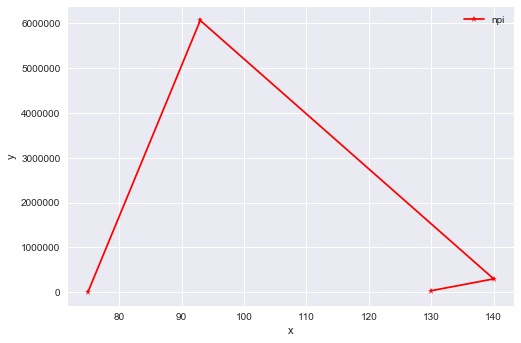

In [19]:
cluster = np.array(cluster_batch_list)[:, 0]
plt.plot(cluster, classification_cost, "r*-", label="npi")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()